### font-test

In [1]:
import os
import sys
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib
from pathlib import Path
from matplotlib import font_manager
from matplotlib import pyplot as plt
from matplotlib.font_manager import FontProperties

import warnings
warnings.filterwarnings('ignore')

In [2]:
def get_cond_omega(ds_pr, ds_tb, ds_omega, time_sel):

    # generate conditional mean of omega500 as a function of Tb and P
    bins_tb = np.linspace(180,280,26)
    bins_pr = np.linspace(0,100,26)
    samples = np.zeros((len(bins_tb)-1, len(bins_pr)-1)) # (mature vs end, bins_tb, bins_pr)
    omega_sum = np.copy(samples)
    nomega_counts = np.copy(samples)
    pomega_counts = np.copy(samples)

    pr_mcs_phase = ds_pr.isel(time=time_sel).values.ravel()
    tb_mcs_phase = ds_tb.isel(time=time_sel).values.ravel()
    omega_mcs_phase = ds_omega.isel(time=time_sel).values.ravel()
    # some missing values may exist in tb
    tb_mcs_mask = tb_mcs_phase[~np.isnan(tb_mcs_phase)]
    omega_mcs_mask = omega_mcs_phase[~np.isnan(tb_mcs_phase)]
    pr_mcs_mask = pr_mcs_phase[~np.isnan(tb_mcs_phase)]

    # MCS life stage
    for i in range(len(bins_tb)-1):
        idx = np.where(np.logical_and(tb_mcs_mask >= bins_tb[i], tb_mcs_mask < bins_tb[i+1]))[0]
        for j in range(len(bins_pr)-1):
            idy = np.where(np.logical_and(pr_mcs_mask >= bins_pr[j], pr_mcs_mask < bins_pr[j+1]))[0]
            idx_com = np.intersect1d(idx,idy)
            samples[i,j] = len(idx_com)
            omega_sum[i,j] = np.sum(omega_mcs_mask[idx_com])
            omega_tmp = omega_mcs_mask[idx_com]
            nomega_counts[i,j] = len(np.where(omega_tmp < -0.01)[0])
            pomega_counts[i,j] = len(np.where(omega_tmp > 0.01)[0])
            
    # writeout as dataset
    ds_omega_cond = xr.Dataset(data_vars=dict(samples = (['bins_tb','bins_pr'], samples),
                                            omega_sum = (['bins_tb','bins_pr'], omega_sum),
                                            pomega_counts = (['bins_tb','bins_pr'], pomega_counts),
                                            nomega_counts = (['bins_tb','bins_pr'], nomega_counts)),
                            coords=dict(bins_tb = (['bins_tb'], bins_tb[:-1]),
                                        bins_pr = (['bins_pr'], bins_pr[:-1]),
                                        )
                            )
    
    return ds_omega_cond

In [3]:
# get normal font and store it in `fira_sans_regular`
personal_path = '/home/wmtsai/anaconda3/fonts/'
font_path = personal_path + 'arial.ttf'
arial_reg = FontProperties(fname=font_path)

In [4]:
%%time
year_list = np.arange(2011,2021)

ds_omega_list = []
for year in year_list:
    print('processing year: {}'.format(year))
    ### get data
    dir_vars2d = Path('/scratch/wmtsai/featenv_analysis/dataset/MCS_FLEXTRKR_tropics/{}/environment_catalogs/VARS_2D'.format(year))
    dir_vars3d = Path('/scratch/wmtsai/featenv_analysis/dataset/MCS_FLEXTRKR_tropics/{}/environment_catalogs/VARS_3D'.format(year))

    ds_mcs = xr.open_dataset(dir_vars2d / 'MCS_FLEXTRKR_tropics_cloudtracknumber_nomergesplit.merged.nc').cloudtracknumber_nomergesplit
    #ds_omega500 = xr.open_dataset(dir_vars2d / 'MCS_FLEXTRKR_tropics_omega500.merged.nc').w.rename('w500')
    ds_omega = xr.open_dataset(dir_vars3d / 'MCS_FLEXTRKR_tropics_omega.merged.nc').w
    ds_omega_ltmean = (ds_omega.sel(level=slice(600,1000)).integrate('level')/400).rename('omega_ltmean')
    ds_pr = xr.open_dataset(dir_vars2d / 'MCS_FLEXTRKR_tropics_precipitation.merged.nc').precipitation
    ds_tb = xr.open_dataset(dir_vars2d / 'MCS_FLEXTRKR_tropics_tb.merged.nc').tb
    ds_mtpr = xr.open_dataset(dir_vars2d /'MCS_FLEXTRKR_tropics_mpr.merged.nc').mtpr

    ds_merged = xr.merge([ds_mcs, ds_omega_ltmean, ds_pr, ds_tb, ds_mtpr], compat='override')
    ds_merged_mcs = ds_merged.where(ds_merged.cloudtracknumber_nomergesplit == ds_merged.tracks + 1)

    dir_stats = Path('/scratch/wmtsai/temp_mcs/mcs_stats/mcs_tracks_non2mcs/tracks_area_mean')    
    ds_stats = xr.open_dataset(dir_stats / 'featstats_tracks_non2mcs_{}.tropics30NS.full.nc'.format(year))
    corr_coeff_space = ds_stats.corr_coeff_space

    # get index for higher spatial correlation tracks
    check_corr_space = np.zeros(len(ds_stats.tracks))
    for n,track in enumerate(ds_stats.tracks):
        corr_mature = corr_coeff_space.sel(tracks=track, mcs_phase='Mature')
        corr_end = corr_coeff_space.sel(tracks=track, mcs_phase='End')
        if (corr_mature > 0.7) and (corr_end > 0.7):
            check_corr_space[n] = 1
        else:
            check_corr_space[n] = 0
    idx_tracks_coeff = np.where(corr_coeff_space ==1)[0]

    # get index for oceanic tracks only (messy for land tracks)
    ds_track = xr.open_dataset(dir_stats / '../mcs_tracks_non2mcs_{}.tropics30NS.full.nc'.format(year))
    idt_mcs_init = ds_track.idt_mcs_init
    ls_flag = ds_track.isel(times=idt_mcs_init).landsea_flag
    idx_tracks_ocean = np.where(ls_flag == 0)[0]

    # combined filtering parameters
    idx_tracks = np.intersect1d(idx_tracks_coeff, idx_tracks_ocean)

    ds_merged_filtered = ds_merged_mcs.isel(tracks=idx_tracks)

    ds_omegalt_mature = get_cond_omega(ds_merged_filtered.precipitation, ds_merged_filtered.tb, ds_merged_filtered.omega_ltmean,
                                      time_sel=3) # mature phase
    ds_omegalt_end = get_cond_omega(ds_merged_filtered.precipitation, ds_merged_filtered.tb, ds_merged_filtered.omega_ltmean,
                                      time_sel=5) # end phase
    ds_omega_merged = xr.concat([ds_omegalt_mature, ds_omegalt_end], pd.Index(['Mature','End'], name='phase'))
    ds_omega_list.append(ds_omega_merged)

# merge all years 
ds_omega_multiyear = xr.concat(ds_omega_list, pd.Index(year_list, name='year')).sum('year')

processing year: 2011
processing year: 2012
processing year: 2013
processing year: 2014
processing year: 2015
processing year: 2016
processing year: 2017
processing year: 2018
processing year: 2019
processing year: 2020
CPU times: user 1min 22s, sys: 6min 21s, total: 7min 43s
Wall time: 7min 45s


In [13]:
# ds_merged = xr.merge([ds_mcs_mask, ds_omega500, ds_omega850, ds_pr, ds_tb], compat='override').drop('level')
# ds_merged_mcs = xr.merge([ds_mcs_mask, omega_500_mcs, omega_850_mcs, pr_mcs, tb_mcs, mtpr_mcs]).drop('level')

In [14]:
# dir_stats = Path('/scratch/wmtsai/temp_mcs/mcs_stats/mcs_tracks_non2mcs/tracks_area_mean')
# ds_stats = xr.open_dataset(dir_stats / 'featstats_tracks_non2mcs_2010.tropics30NS.full.nc')
# corr_coeff_temp = ds_stats.corr_coeff_temp
# idx_tracks = np.where(corr_coeff_temp > 0.7)[0]

# ds_merged_filtered = ds_merged_mcs.isel(tracks=idx_tracks)

In [ ]:
track_sel = 600
ds_merged.isel(tracks=track_sel, time=5).precipitation.plot(cmap='jet', vmin=0)
cf = ds_merged.isel(tracks=track_sel, time=5).w500.plot.contour(levels=np.arange(-2,2,0.5), cmap='RdBu')
plt.clabel(cf)
ds_merged.isel(tracks=track_sel, time=5).cloudtracknumber_nomergesplit.plot(alpha=0.8,zorder=3)

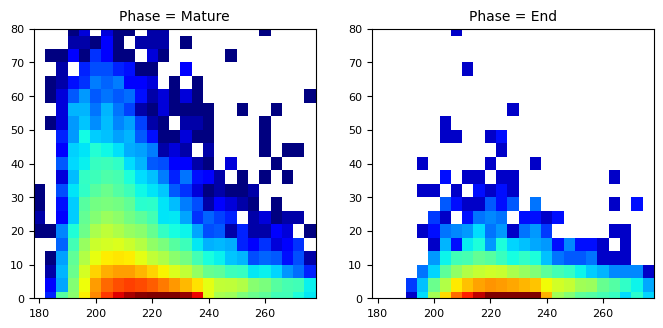

In [5]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(8,3.5))
tmp = ds_omega_multiyear.sel(phase='Mature').samples
joint_pdf_mature = tmp/tmp.sum()
tmp = ds_omega_multiyear.sel(phase='End').samples
joint_pdf_end = tmp/tmp.sum()

pdf_diff = joint_pdf_end - joint_pdf_mature

ax1.pcolormesh(tmp.bins_tb, tmp.bins_pr, np.log10(joint_pdf_mature).T,vmin=-5,vmax=-1,cmap='jet')
ax2.pcolormesh(tmp.bins_tb, tmp.bins_pr, np.log10(joint_pdf_end).T,vmin=-5,vmax=-1,cmap='jet')

ax1.tick_params(labelsize=8)
ax2.tick_params(labelsize=8)

ax1.set_title('Phase = Mature', fontsize=10)
ax2.set_title('Phase = End', fontsize=10)
ax1.set_ylim([0,80])
ax2.set_ylim([0,80])

plt.show()

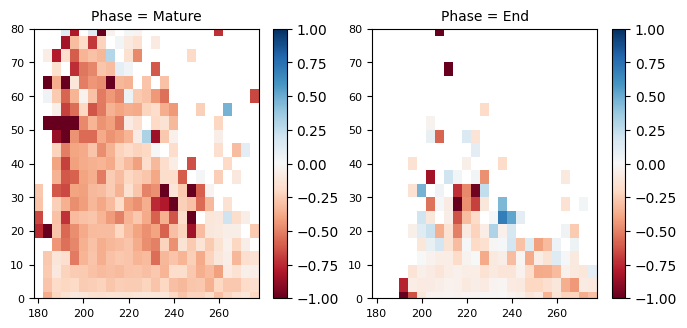

In [6]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(8,3.5))
tmp = ds_omega_multiyear.sel(phase='Mature').omega_sum
omega_cond_mature = tmp/ds_omega_multiyear.sel(phase='Mature').samples
tmp = ds_omega_multiyear.sel(phase='End').omega_sum
omega_cond_end = tmp/ds_omega_multiyear.sel(phase='End').samples

# conditional omega at 850hPa
cp1 = ax1.pcolormesh(tmp.bins_tb, tmp.bins_pr, omega_cond_mature.T ,vmin=-1,vmax=1,cmap='RdBu')
cp2 = ax2.pcolormesh(tmp.bins_tb, tmp.bins_pr, omega_cond_end.T ,vmin=-1,vmax=1,cmap='RdBu')
plt.colorbar(cp1,ax=ax1)
plt.colorbar(cp2,ax=ax2)

ax1.tick_params(labelsize=8)
ax2.tick_params(labelsize=8)

ax1.set_title('Phase = Mature', fontsize=10)
ax2.set_title('Phase = End', fontsize=10)
ax1.set_ylim([0,80])
ax2.set_ylim([0,80])

plt.show()

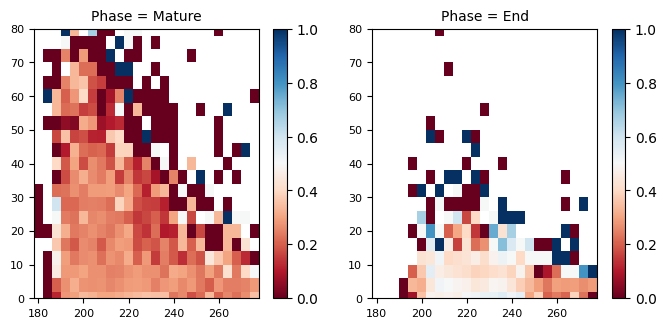

In [10]:
# fraction of downdraft 
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(8,3.5))
ud_counts = ds_omega_multiyear.sel(phase='Mature').nomega_counts
dd_counts = ds_omega_multiyear.sel(phase='Mature').pomega_counts
dd_fract_mature = dd_counts / (ud_counts + dd_counts)
ud_counts = ds_omega_multiyear.sel(phase='End').nomega_counts
dd_counts = ds_omega_multiyear.sel(phase='End').pomega_counts
dd_fract_end = dd_counts / (ud_counts + dd_counts)

dd_fract_mature_mask = dd_fract_mature.where(joint_pdf_mature > 0)
dd_fract_end_mask = dd_fract_end.where(joint_pdf_end > 0)

# conditional omega at 850hPa
cp1 = ax1.pcolormesh(tmp.bins_tb, tmp.bins_pr, dd_fract_mature_mask.T ,vmin=0,vmax=1,cmap='RdBu')
cp2 = ax2.pcolormesh(tmp.bins_tb, tmp.bins_pr, dd_fract_end_mask.T ,vmin=0,vmax=1,cmap='RdBu')
plt.colorbar(cp1,ax=ax1)
plt.colorbar(cp2,ax=ax2)

ax1.tick_params(labelsize=8)
ax2.tick_params(labelsize=8)

ax1.set_title('Phase = Mature', fontsize=10)
ax2.set_title('Phase = End', fontsize=10)
ax1.set_ylim([0,80])
ax2.set_ylim([0,80])

plt.show()

In [ ]:
tmp = xr.open_dataset('/scratch/wmtsai/ISCCP.HXG.v01r00.GLOBAL.2010.01.01.0900.GPC.10KM.CS0968209712.EQ0.10.nc')
tmp

In [ ]:
tmp.vprs.plot()